In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import time
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import deepxde as dde

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
/home/luke/miniconda3/lib/python3.12/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403380481/work/torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [2]:
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

In [3]:
import torch

class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(UnitGaussianNormalizer, self).__init__()

        self.mean = torch.mean(x, 0)
        self.std = torch.std(x, 0)
        self.eps = eps

    def encode(self, x):
        x = (x-self.mean)/(self.std + self.eps)
        return x

    def decode(self, x):
        std = self.std+self.eps
        mean = self.mean

        x = (x*std) + mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()

In [5]:
coms = np.array([[-0.05117, 0.07908, 0.00086, 1],
                 [0.00269, -0.00529, 0.06845, 1],
                 [-0.07176, 0.08149, 0.00132, 1],
                 [0.00159, -0.01117, 0.02618, 1],
                 [-0.01168, 0.13111, 0.0046, 1],
                 [0.00697, 0.006, 0.06048, 1],
                 [0.005137, 0.0009572, -0.06682, 1]])
# Ixx, Iyy, Izz, Ixy, Iyz, Ixz
inertias = np.array([[0.0470910226, 0.035959884, 0.0376697645, -0.0061487003, -0.0007808689, 0.0001278755],
[0.027885975, 0.020787492, 0.0117520941,-0.0001882199, 0.0020767576, -0.00030096397],
[0.0266173355, 0.012480083, 0.0284435520,-0.0039218988, -0.001083893, 0.0002927063],
[0.0131822787, 0.009268520, 0.0071158268,-0.0001966341, 0.000745949, 0.0003603617],
[0.0166774282, 0.003746311, 0.0167545726,-0.0001865762, 0.0006473235, 0.0001840370],
[0.0070053791, 0.005527552, 0.0038760715,0.0001534806, -0.0002111503, -0.000443847],
[0.0008162135, 0.0008735012, 0.0005494148,0.000128440, 0.0001057726, 0.00018969891]])

# theta, d, a, alpha, m
dh_params = np.array([[0.2703, 0.069, -math.pi/2, 5.70044],
[0, 0, math.pi/2, 3.22698],
[0.3644, 0.069, -math.pi/2, 4.31272],
[0, 0, math.pi/2, 2.07206],
[0.3743, 0.01, -math.pi/2, 2.24665],
[0, 0, math.pi/2, 1.60979],
[0.2295,  0, 0, 0.54218]])

dof = 3
a = np.zeros(dof)
d = np.zeros(dof)
alpha = np.zeros(dof)
m = np.zeros(dof)
for i in range(dof):
    a[i] = dh_params[i, 1]
    d[i] = dh_params[i, 0]
    alpha[i] = dh_params[i, 2]
    m[i] = dh_params[i, 3]

J = np.zeros((4,4,dof))
for i in range(dof):
    J[:,:,i] = [[0.5*(-inertias[i,0]+inertias[i, 1]+inertias[i, 2]),inertias[i, 3],inertias[i,5], m[i]*coms[i, 0]],\
                    [inertias[i, 3], 0.5*(inertias[i,0]-inertias[i, 1]+inertias[i, 2]), inertias[i, 4], m[i]*coms[i, 1]], \
                    [inertias[i, 5], inertias[i, 4], 0.5*(inertias[i,0]+inertias[i, 1]-inertias[i, 2]), m[i]*coms[i, 2]], \
                     [m[i]*coms[i, 0], m[i]*coms[i, 1], m[i]*coms[i, 2], m[i]]]
    
Q = np.zeros((4,4))
Q[0,1] = -1
Q[1,0] = 1

In [6]:
def compute_matrices(q, qdot):
    T01 = np.array([[math.cos(q[0]),  -math.cos(alpha[0])*math.sin(q[0]),  math.sin(alpha[0])*math.sin(q[0]), a[0]*math.cos(q[0])],
           [math.sin(q[0]),   math.cos(alpha[0])*math.cos(q[0]), -math.sin(alpha[0])*math.cos(q[0]), a[0]*math.sin(q[0])],
           [0,           math.sin(alpha[0]),            math.cos(alpha[0]),           d[0]],
           [0,           0,                        0,                       1]])   

    
    T12 = np.array([[math.cos(q[1]),  -math.cos(alpha[1])*math.sin(q[1]),  math.sin(alpha[1])*math.sin(q[1]), a[1]*math.cos(q[1])],
           [math.sin(q[1]),   math.cos(alpha[1])*math.cos(q[1]), -math.sin(alpha[1])*math.cos(q[1]), a[1]*math.sin(q[1])],
           [0,           math.sin(alpha[1]),            math.cos(alpha[1]),           d[1]],
           [0,           0,                        0,                       1]])

    T23 = np.array([[math.cos(q[2]),  -math.cos(alpha[2])*math.sin(q[2]),  math.sin(alpha[2])*math.sin(q[2]), a[2]*math.cos(q[2])],
           [math.sin(q[2]),   math.cos(alpha[2])*math.cos(q[2]), -math.sin(alpha[2])*math.cos(q[2]), a[2]*math.sin(q[2])],
           [0,           math.sin(alpha[2]),            math.cos(alpha[2]),           d[2]],
           [0,           0,                        0,                       1]])

    
    T34 = np.array([[math.cos(q[3]),  -math.cos(alpha[3])*math.sin(q[3]),  math.sin(alpha[3])*math.sin(q[3]), a[3]*math.cos(q[3])],
           [math.sin(q[3]),     math.cos(alpha[3])*math.cos(q[3]), -math.sin(alpha[3])*math.cos(q[3]), a[3]*math.sin(q[3])],
           [0,                 math.sin(alpha[3]),                 math.cos(alpha[3]),               d[3]],
           [0,           0,                        0,                       1]])

        
    T45 = np.array([[math.cos(q[4]),  -math.cos(alpha[4])*math.sin(q[4]),  math.sin(alpha[4])*math.sin(q[4]), a[4]*math.cos(q[4])],
           [math.sin(q[4]),     math.cos(alpha[4])*math.cos(q[4]), -math.sin(alpha[4])*math.cos(q[4]), a[4]*math.sin(q[4])],
           [0,                 math.sin(alpha[4]),                 math.cos(alpha[4]),               d[4]],
           [0,           0,                        0,                       1]])

        
    T56 = np.array([[math.cos(q[5]),  -math.cos(alpha[5])*math.sin(q[5]),  math.sin(alpha[5])*math.sin(q[5]), a[5]*math.cos(q[5])],
           [math.sin(q[5]),     math.cos(alpha[5])*math.cos(q[5]), -math.sin(alpha[5])*math.cos(q[5]), a[5]*math.sin(q[5])],
           [0,                 math.sin(alpha[5]),                 math.cos(alpha[5]),               d[5]],
           [0,           0,                        0,                       1]]) 

        
    T67 = np.array([[math.cos(q[6]),  -math.cos(alpha[6])*math.sin(q[6]),  math.sin(alpha[6])*math.sin(q[6]), a[6]*math.cos(q[6])],
           [math.sin(q[6]),     math.cos(alpha[6])*math.cos(q[6]), -math.sin(alpha[6])*math.cos(q[6]), a[6]*math.sin(q[6])],
           [0,                 math.sin(alpha[6]),                 math.cos(alpha[6]),               d[6]],
           [0,           0,                        0,                       1]])  

    T00 = np.identity(4);
    T11 = np.identity(4);
    T22 = np.identity(4);
    T33 = np.identity(4);
    T44 = np.identity(4);
    T55 = np.identity(4);
    T66 = np.identity(4);
    T77 = np.identity(4);
    
    T02 = (T01@T12);
    T03 = (T02@T23);
    T04 = (T03@T34);
    T05 = (T04@T45);
    T06 = (T05@T56);
    T07 = (T06@T67);
    
    T13 = (T12@T23);
    T14 = (T13@T34);
    T15 = (T14@T45);
    # T16 = (T15@T56);
    # T17 = (T16@T67);
    
    # T24 = (T23@T34);
    # T25 = (T24@T45);
    # T26 = (T25@T56);
    # T27 = (T26@T67);
    
    # T35 = (T34@T45);
    # T36 = (T35@T56);
    # T37 = (T36@T67);
    
    # T46 = (T45@T56);
    # T47 = (T46@T67);
    
    # T57 = (T56@T67);


    U = np.zeros((4,4,dof,dof));
    for i in range(1,dof+1):
        for j in range(1, dof+1):
            if j <= i:
                U[:,:,i-1,j-1] = eval('T'+str(0)+str(j-1)) @ Q @ eval('T' + str(j-1) + str(i))
            else:
                U[:,:,i-1,j-1] = np.zeros((4, 4)); 
    
    U3 = np.zeros((4,4,dof, dof, dof));
    for i in range(1, dof+1):
        for j in range(1, dof+1):
            for k in range(1, dof+1):
                if (i >= k) and (k >= j):
                    U3[:,:,i-1,j-1,k-1] = eval('T'+str(0)+str(j-1)) @ Q @ eval('T'+str(j-1)+str(k-1)) @ Q @ eval('T'+str(k-1)+str(i))
                elif (i >= j) and (j >= k):
                    U3[:,:,i-1,j-1,k-1] = eval('T'+str(0)+str(k-1)) @ Q @ eval('T'+str(k-1)+str(j-1)) @ Q @ eval('T'+str(j-1)+str(i))
                else:
                    U3[:,:,i-1,j-1,k-1] = np.zeros((4, 4))

    
    # Inertia
    D = np.zeros((dof, dof))
    for i in range(0, dof):
        for k in range(0, dof):
            res = 0;
            for j in range(max(i,k), dof):
                res = res + np.trace(U[:,:,j,k]@J[:,:,j]@(U[:,:,j,i].T))
            D[i,k] = res;

    # Coriolis
    h3 = np.zeros((dof, dof, dof))
    for i in range(0, dof):
        for k in range(0, dof):
            for m_idx in range(0, dof):
                res = 0;
                for j in range(max([i, k, m_idx]), dof):
                    res = res + np.trace(U3[:,:,j,k,m_idx] @ J[:,:,j] @ (U[:,:,j,i].T))
                h3[i,k,m_idx] = res;
    h = np.zeros(dof);
    for i in range(dof):
        sum_k = 0
        for k in range(dof):
            sum_m = 0
            for m_idx in range(dof):
                sum_m = sum_m + h3[i,k,m_idx] * qdot[k] * qdot[m_idx]
            sum_k = sum_k + sum_m
        h[i] = sum_k;

    # Gavity
    g = 9.81
    g_vec = np.array([0, 0, -g, 0]);
    c = np.zeros(dof);
    for i in range(dof):
        res = 0;
        for j in range(dof):
            res = res + (-m[j] * g_vec @ U[:,:,j,i] @ coms[j]);
        c[i] = res;

    return D, h, c

In [7]:
def step_q(states, torque):
    x1 = states[:dof]
    x2 = states[dof:]
    M, C, G = compute_matrices(x1, x2)
    x1dot = x2
    x2dot = np.linalg.inv(M) @ (torque - C @ x2 - G)
    return np.array([x1dot, x2dot]).reshape(2*dof)

def get_error_states(states, qdes, qdesdot):
    x1 = states[:dof]
    x2 = states[dof:]
    e1 = qdes - x1
    e2 = (qdesdot - x2) + alpha_mat @ e1
    return np.array([e1, e2]).reshape(2*dof)

def compute_control(states, qdes, qdesdot, qdesddot):
    x1 = states[:dof]
    x2 = states[dof:]
    error_states = get_error_states(states, qdes, qdesdot)
    e1 = error_states[:dof]
    e2 = error_states[dof:]
    M, C, G = compute_matrices(x1, x2)
    h = qdesddot - alpha_mat @ alpha_mat @ e1 + np.linalg.inv(M) @ (C@qdesdot + G + C @ alpha_mat @ e1 - C @ e2)
    return saturate_torques(M @ (h + (beta_mat + alpha_mat)@ e2))

def saturate_torques(torque):
    min_torques = [-50, -50, -50, -50, -15, -15, -15]
    min_torques = min_torques[0:dof]
    max_torques = [50, 50, 50, 50, 15, 15, 15]    
    max_torques = max_torques[0:dof]
    return np.maximum(min_torques, np.minimum(max_torques, torque))

def saturate_joints(joints):
    joint_lim_min = np.array([-1.7016, -2.147, -3.0541, -0.05, -3.059, -1.571, -3.059])
    joint_lim_min_deriv = np.array([-2, -2, -2, -2, -4, -4, -4])
    joint_lim_max = np.array([1.7016, 1.047, 3.0541, 2.618, 3.059, 2.094, 3.059])
    joint_lim_max_deriv = np.array([2, 2, 2, 2, 4, 4, 4])
    joint_lim_min = np.array([joint_lim_min[0:dof], joint_lim_min_deriv[0:dof]]).reshape(2*dof)
    joint_lim_max = np.array([joint_lim_max[0:dof], joint_lim_max_deriv[0:dof]]).reshape(2*dof)
    return np.maximum(joint_lim_min, np.minimum(joint_lim_max, joints))

def compute_predictors(X, controls, _model):
    res = np.zeros((len(controls)+1, len(X)))
    res[0] = np.copy(X)
    for i in range(len(controls)):
        res[i+1] = saturate_joints(res[i] + dt*step_q(res[i], controls[i]))
    return res[-1], res[1:]

def simulate_system(x0, qdes, qdesdot, qdesddot, dt, T, D, dof, predictor_func, model, randomize=False):
    t = np.arange(0, T, dt)
    q_vals = np.zeros((len(t), len(x0)))
    nD = int(round(D/dt))
    controls = np.zeros((len(t)+nD, dof))
    predictors = np.zeros((len(t), nD, len(x0)), dtype=np.float32)
    q_vals[0] = x0
    # Setup initial controllers. This matters - ALOT. 
    controllerStatic = compute_control(q_vals[0], q_vals[0, :dof], np.zeros(dof), np.zeros(dof))
    controls[0:nD, :] = controllerStatic
    for i in range(1, len(t)):
        if i % 100 == 0:
            print(i, "/", len(t))
        if i > nD:
            if randomize:
                prediction, predictions_arr = predictor_func(q_vals[i-1], controls[i-1:i-1+nD], model) 
                prediction = prediction + np.random.uniform(-0.1, 0.1, 2*dof)
            else:
                prediction, predictions_arr = predictor_func(q_vals[i-1], controls[i-1:i-1+nD], model) 
            controls[i-1+nD] = compute_control(prediction, qdes[i-1+nD], qdesdot[i-1+nD], qdesddot[i-1+nD])
            if predictions_arr is not None:
                predictors[i] = predictions_arr
        else:
            controls[i-1+nD] = compute_control(q_vals[i-1], qdes[i-1+nD], qdesdot[i-1+nD], qdesddot[i-1+nD])
            predictors[i] = np.tile(q_vals[i-1], nD).reshape(nD, len(q_vals[i-1]))
        #controls[i-1+nD] = compute_control(prediction+ np.random.uniform(-0.5, 0.5, 2*dof), qdes[i-1+nD], qdesdot[i-1+nD], qdesddot[i-1+nD])
        q_vals[i] =  saturate_joints(q_vals[i-1] + dt*step_q(q_vals[i-1], controls[i-1]))
    return q_vals, controls, predictors

In [8]:
joint_lim_min = np.array([-1.7016, -2.147, -3.0541, -0.05, -3.059, -1.571, -3.059])
joint_lim_max = np.array([1.7016, 1.047, 3.0541, 2.618, 3.059, 2.094, 3.059])
joint_lim_min = joint_lim_min[0:dof]
joint_lim_max = joint_lim_max[0:dof]

# Generate a trajecotry:
def generate_trajectory(joint_lim_min, joint_lim_max, scaling, dt, T, D, y_shift):
    t = np.arange(0, T+D, dt)
    q = np.zeros((len(t), len(joint_lim_min)))
    qd= np.zeros((len(t), len(joint_lim_min)))
    qdd = np.zeros((len(t), len(joint_lim_min)))
    for i in range(len(t)):
        # ensures positive q so we are in the joints
        q[i] = [math.sin(t[i]*period)*scaling ]*len(joint_lim_min) + y_shift
        qd[i] = [math.cos(t[i]*period)*scaling*period]*len(joint_lim_min)
        qdd[i] = [-math.sin(t[i]*period)*scaling*period**2] * len(joint_lim_min)
        if (np.maximum(np.minimum(q[i], joint_lim_max), joint_lim_min) != q[i]).any():
            raise Exception("Trajectory not feasible")
    return q, qd, qdd

T = 10
period = 1
dt = 0.1
scaling = 0.1
t = np.arange(0, T, dt)
# Handles delays up to any time essentially
D = 0.5
nD = int(round(D/dt))

In [9]:
init_cond = (joint_lim_max + joint_lim_min) / 2.0
y_shift = init_cond
qdes, qd_des, qdd_des = generate_trajectory(joint_lim_min, joint_lim_max, 0.1, dt, T, D, y_shift)
init_cond = np.array([init_cond, np.zeros(dof)]).reshape(2*dof)
alpha_mat = np.identity(dof)
beta_mat = np.identity(dof)
statesExact, controlsExact, predictorsExact = simulate_system(init_cond, qdes, qd_des, qdd_des, dt, T, D, dof, compute_predictors, None, False)

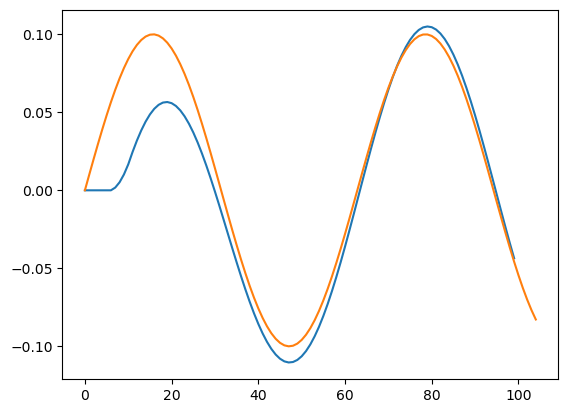

In [10]:
plt.plot(statesExact[:, 0])
plt.plot(qdes[:, 0])

In [178]:
# Build dataset
def gen_dataset(num_data, dt, T, dof, D, joint_lim_min, joint_lim_max, deviation):
    t = np.arange(0, T, dt)
    qdes, qd_des, qdd_des = generate_trajectory(joint_lim_min, joint_lim_max, scaling, dt, T, D,(joint_lim_max + joint_lim_min) / 2.0  )
    # if(num_data % sample_rate != 0):
    #     raise Exception("Please ensure num_data % sample_rate = 0")
    # if(len(t) % sample_rate != 0):
    #     raise Exception("Please ensure int(T/dt)+1 % sample_rate = 0")
    nD = int(round(D/dt))
    inputs = np.zeros((num_data, nD, 3*dof))
    outputs = np.zeros((num_data, nD, 2*dof))
    index = 0
    num_pdes = 0
    start_time = time.time()
    sample_rate  =  len(np.arange(0, len(t)-1)[nD+1:])
    print("Generating", num_data, "values with sample rate", sample_rate)
    print("This will require simulating", math.ceil(num_data/sample_rate), "trajectories")
    start_time = time.time()
    last_time = start_time
    while index+1 < num_data:
        # sample_locs = np.random.choice(np.arange(int(len(t)/sample_rate)-1, len(t)-1)[nD+1:], size=sample_rate, replace=False)
        sample_locs = np.arange(0, len(t)-1)[nD+1:]
        if num_pdes % 5 == 0:
            print("Simulated Trajectories: ", num_pdes, "/",  math.ceil(num_data/sample_rate))
            print("Total time per trajectory", time.time()-last_time)
            print("Total time spent", time.time()-start_time)
            last_time = time.time()
        num_pdes += 1
        #init_cond = np.random.uniform(joint_lim_min + deviation*np.ones(len(joint_lim_min)), joint_lim_max - np.ones(len(joint_lim_max)))
        init_cond = init_cond = (joint_lim_max + joint_lim_min) / 2.0 + np.random.uniform(-0.1, 0.1,dof)
        init_cond = np.array([init_cond, np.zeros(dof)]).reshape(2*dof) 
        #states, controls, predictors = simulate_system(init_cond, qdes, qd_des, qdd_des, dt, T, D, dof, ml_predictor_deeponet, modelDeepONet)
        states, controls, predictors = simulate_system(init_cond, qdes, qd_des, qdd_des, dt, T, D, dof, compute_predictors, None, randomize=False)
        for i in range(len(sample_locs)):
            val = sample_locs[i]
            myStates = states[val-1] 
            myControls = controls[val-1:val-1+nD] 
            inputs[index, :, 0:2*dof] =  np.tile(myStates, nD).reshape(nD, 2*dof)
            inputs[index, :, 2*dof:] = myControls
            outputs[index] = compute_predictors(myStates, myControls, None)[1]
            index += 1
            if index+1 >= num_data:
                break
    end_time = time.time()
    inputs = inputs.reshape((num_data, nD*3*dof))
    outputs = outputs.reshape((num_data, nD*2*dof))
    np.save("inputs3DOFInitRandomizedLarge.npy", inputs)
    np.save("outputs3DOFInitRandomizedLarge.npy", outputs)
    print("Generated successfully. Total time:", end_time-start_time)

# Build dataset
def gen_finetune_dataset(num_data, dt, T, dof, D, joint_lim_min, joint_lim_max, deviation, model, ml_predictor_func):
    t = np.arange(0, T, dt)
    qdes, qd_des, qdd_des = generate_trajectory(joint_lim_min, joint_lim_max, scaling, dt, T, D)
    # if(num_data % sample_rate != 0):
    #     raise Exception("Please ensure num_data % sample_rate = 0")
    # if(len(t) % sample_rate != 0):
    #     raise Exception("Please ensure int(T/dt)+1 % sample_rate = 0")
    nD = int(round(D/dt))
    inputs = np.zeros((num_data, nD, 3*dof))
    outputs = np.zeros((num_data, nD, 2*dof))
    index = 0
    num_pdes = 0
    start_time = time.time()
    sample_rate  =  len(np.arange(0, len(t)-1)[nD+1:])
    print("Generating", num_data, "values with sample rate", sample_rate)
    print("This will require simulating", math.ceil(num_data/sample_rate), "trajectories")
    start_time = time.time()
    last_time = start_time
    while index+1 < num_data:
        # sample_locs = np.random.choice(np.arange(int(len(t)/sample_rate)-1, len(t)-1)[nD+1:], size=sample_rate, replace=False)
        sample_locs = np.arange(0, len(t)-1)[nD+1:]
        if num_pdes % 5 == 0:
            print("Simulated Trajectories: ", num_pdes, "/",  math.ceil(num_data/sample_rate))
            print("Total time per trajectory", time.time()-last_time)
            print("Total time spent", time.time()-start_time)
            print("index", index)
            last_time = time.time()
        num_pdes += 1
        #init_cond = np.random.uniform(joint_lim_min + deviation*np.ones(len(joint_lim_min)), joint_lim_max - np.ones(len(joint_lim_max)))
        init_cond = (joint_lim_max + joint_lim_min) / 2.0 + np.random.uniform(-1,1,dof)
        init_cond = np.array([init_cond, np.zeros(dof)]).reshape(2*dof) 
        states, controls, predictors = simulate_system(init_cond, qdes, qd_des, qdd_des, dt, T, D, dof, ml_predictor_func, model, False)
        #states, controls, predictors = simulate_system(init_cond, qdes, qd_des, qdd_des, dt, T, D, dof, compute_predictors, None, randomize=True)
        for i in range(len(sample_locs)):
            val = sample_locs[i]
            myStates = states[val-1] 
            myControls = controls[val-1:val-1+nD]
            inputs[index, :, 0:2*dof] =  np.tile(myStates, nD).reshape(nD, 2*dof)
            inputs[index, :, 2*dof:] = myControls
            outputs[index] = compute_predictors(myStates, myControls, None)[1]
            index += 1
            if index+1 >= num_data:
                break
    end_time = time.time()
    inputs = inputs.reshape((num_data, nD*3*dof))
    outputs = outputs.reshape((num_data, nD*2*dof))
    np.save("inputsFineTune.npy", inputs)
    np.save("outputsFineTune.npy", outputs)
    print("Generated successfully. Total time:", end_time-start_time)


In [ ]:
alpha_mat = np.identity(dof)*2
beta_mat = np.identity(dof)*2
gen_dataset(250000, dt, T, dof, D, joint_lim_min, joint_lim_max, 2)

Generating 250000 values with sample rate 93
This will require simulating 2689 trajectories
Simulated Trajectories:  0 / 2689
Total time per trajectory 8.344650268554688e-06
Total time spent 1.52587890625e-05
Simulated Trajectories:  5 / 2689
Total time per trajectory 2.5651419162750244
Total time spent 2.565166473388672
Simulated Trajectories:  10 / 2689
Total time per trajectory 2.4965696334838867
Total time spent 5.061744451522827
Simulated Trajectories:  15 / 2689
Total time per trajectory 2.5020387172698975
Total time spent 7.563791990280151
Simulated Trajectories:  20 / 2689
Total time per trajectory 2.497192144393921
Total time spent 10.060991525650024
Simulated Trajectories:  25 / 2689
Total time per trajectory 2.4977993965148926
Total time spent 12.558799505233765
Simulated Trajectories:  30 / 2689
Total time per trajectory 2.495849847793579
Total time spent 15.054656744003296
Simulated Trajectories:  35 / 2689
Total time per trajectory 2.495394229888916
Total time spent 17.55

In [ ]:
# Loading float32 does introduce some small numerical error, but not large. 
alpha_mat = np.identity(dof)
beta_mat = np.identity(dof)
inputs = np.load("inputs3DOFInitRandomizedLarge.npy").astype(np.float32)
outputs = np.load("outputs3DOFInitRandomizedLarge.npy").astype(np.float32)
# inputsTune = np.load("inputsTune.npy").astype(np.float32)
# outputsTune = np.load("outputsTune.npy").astype(np.float32)
# inputs = np.concatenate([inputs, inputsTune])
# outputs = np.concatenate([outputs, outputsTune])

In [ ]:
# Parametersdetach
epochs =100
ntrain = 900
ntest = 100
batch_size = 2048
gamma = 0.98
learning_rate = 0.0003
weight_decay=1.5e-2

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
# XNormalizer = UnitGaussianNormalizer(x_train)
# x_train = XNormalizer.encode(x_train)
# x_test = XNormalizer.encode(x_test)

y_train = torch.from_numpy(y_train).cuda()
y_test = torch.from_numpy(y_test).cuda()
# YNormalizer = UnitGaussianNormalizer(y_train)
# y_train = YNormalizer.encode(y_train)
# y_test = YNormalizer.encode(y_test)

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))

In [ ]:
class DeepONetProjected(nn.Module):
    def __init__(self, m, dim_x, proj1, proj2):
        super().__init__()
        width = 256
        self.deeponet = dde.nn.DeepONetCartesianProd([m, 128, 128, 128], [dim_x, 128, 128, 128], "relu", "Glorot normal").cuda()
        self.linear1 = torch.nn.Linear(m, proj1)
        self.linear2 = torch.nn.Linear(proj1, proj2)

    def forward(self, x):
        y = self.deeponet(x)
        y = self.linear1(y)
        return self.linear2(y)


class GRUNet(nn.Module):
    def __init__(self, hidden_size, num_layers, n_input_channel, n_output_channel):
        super(GRUNet, self).__init__()
        self.rnn = nn.GRU(n_input_channel, hidden_size, num_layers, batch_first=True)
        self.projection = nn.Linear(hidden_size, n_output_channel)

    def forward(self, x: torch.Tensor):
        output, (_) = self.rnn(x)
        x = self.projection(output)
        return x

In [ ]:
spatial = np.arange(0, D, dt/(3*dof)).astype(np.float32)
grid=torch.from_numpy(spatial.reshape((len(spatial), 1))).cuda()
print(grid.shape)

In [ ]:
def train_model(model, num_epochs,gamma, lr, weight_decay, model_type):
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    loss = torch.nn.MSELoss()
    train_lossArr = []
    test_lossArr = []
    time_Arr = []
    
    for ep in range(num_epochs):
        model.train()
        t1 = time.time()
        train_loss = 0
        for x_vals, y_vals in trainData:
            x_vals, y_vals = x_vals.cuda(), y_vals.cuda()
            optimizer.zero_grad()
            if model_type == "DeepONet":
                out = model((x_vals, grid))
            elif model_type == "GRU":
                x_vals = x_vals.reshape(x_vals.shape[0], nD, 3*dof)
                y_vals = y_vals.reshape(y_vals.shape[0], nD, 2*dof)
                out = model(x_vals)
            else:
                out = model(x_vals)
    
            lp = loss(out, y_vals)
            lp.backward()
            
            optimizer.step()
            train_loss += lp.item()
            
        scheduler.step()
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for x_vals, y_vals in testData:
                x_vals, y_vals = x_vals.cuda(), y_vals.cuda()
                if model_type == "DeepONet":
                    out = model((x_vals, grid))
                elif model_type == "GRU":
                    x_vals = x_vals.reshape(x_vals.shape[0], nD, 3*dof)
                    y_vals = y_vals.reshape(y_vals.shape[0], nD, 2*dof)
                    out = model(x_vals)
                else:
                    out = model(x_vals)
    
                test_loss += loss(out, y_vals).item()
                
        train_loss /= len(trainData)
        test_loss /= len(testData)
        
        train_lossArr.append(train_loss)
        test_lossArr.append(test_loss)
        
        t2 = time.time()
        time_Arr.append(t2-t1)
        if ep%5 == 0:
            print(ep, t2-t1, train_loss, test_loss)
    return model, train_lossArr, test_lossArr
    
def evaluate_model(model, name, train_lossArr, test_lossArr):
    print("Evaluating model", name)
    # Display Model Details
    plt.figure()
    plt.title("Loss function "+name)
    plt.plot(train_lossArr, label="Train Loss")
    plt.plot(test_lossArr, label="Test Loss")
    plt.yscale("log")
    plt.legend()
        
    print("Final Testing Loss:", test_lossArr[-1])
    print("Final Training Loss:", train_lossArr[-1])

In [ ]:
#modelDeepONet = DeepONetProjected(grid.shape[0], 1, 48, nD*2*dof).cuda()
modelGRU = GRUNet(64, 5, 3*dof, 2*dof).cuda()

In [ ]:
#modelDeepONet, train_lossArrDeepONet, test_lossArrDeepONet = train_model(modelDeepONet, 200,0.98, 3e-3,1.5e-2,  "DeepONet")
modelGRU, train_lossArrGRU, test_lossArrGRU = train_model(modelGRU, 100, 0.999, 9.5e-3, 5e-6, "GRU")

In [ ]:
#evaluate_model(modelDeepONet, "DeepONet", train_lossArrDeepONet, test_lossArrDeepONet)
evaluate_model(modelGRU, "GRU", train_lossArrGRU, test_lossArrGRU)

In [810]:
gen_finetune_dataset(10000, dt, T, dof, D, joint_lim_min, joint_lim_max, 2,modelGRU, ml_predictor_rnn)
inputs = np.load("inputs5DOFTrajRandomized.npy").astype(np.float32)
outputs = np.load("outputs5DOFTrajRandomized.npy").astype(np.float32)
inputsTune = np.load("inputsFineTune.npy").astype(np.float32)
outputsTune = np.load("outputsFineTune.npy").astype(np.float32)
inputs = np.concatenate([inputs, inputsTune])
outputs = np.concatenate([outputs, outputsTune])

Generating 10000 values with sample rate 193
This will require simulating 52 trajectories
Simulated Trajectories:  0 / 52
Total time per trajectory 8.821487426757812e-06
Total time spent 1.52587890625e-05
index 0
100 / 200
100 / 200
100 / 200
100 / 200
100 / 200
Simulated Trajectories:  5 / 52
Total time per trajectory 12.760812520980835
Total time spent 12.760840654373169
index 965
100 / 200
100 / 200
100 / 200
100 / 200
100 / 200
Simulated Trajectories:  10 / 52
Total time per trajectory 13.010658740997314
Total time spent 25.77151131629944
index 1930
100 / 200
100 / 200
100 / 200
100 / 200
100 / 200
Simulated Trajectories:  15 / 52
Total time per trajectory 13.028913497924805
Total time spent 38.80043816566467
index 2895
100 / 200
100 / 200
100 / 200
100 / 200
100 / 200
Simulated Trajectories:  20 / 52
Total time per trajectory 12.76783299446106
Total time spent 51.56828284263611
index 3860
100 / 200
100 / 200
100 / 200
100 / 200
100 / 200
Simulated Trajectories:  25 / 52
Total time

In [811]:
x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
x_test = torch.from_numpy(x_test).cuda()

y_train = torch.from_numpy(y_train).cuda()
y_test = torch.from_numpy(y_test).cuda()

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))

0 3.1002895832061768 0.06352521248359595 0.0525215480190057
5 3.3572237491607666 0.03595305816064366 0.03478159139362665
10 3.410630702972412 0.031358023874659455 0.030917255781017818
15 3.0163090229034424 0.028556971818999907 0.028365671491393678
20 3.1004981994628906 0.026544274877657932 0.026379904064994592
25 3.3902711868286133 0.024520594082706796 0.0247725138010887
30 3.29211688041687 0.023006478852007243 0.0239811627051005
35 3.0077075958251953 0.021625926773747906 0.022423208547899358
40 3.0688140392303467 0.020768929635528968 0.021571216889872
45 3.3401477336883545 0.019790991942966935 0.020933591975615576
50 3.3537566661834717 0.019269579741279637 0.020348269349107377
55 3.044599771499634 0.018580564755155186 0.019838926740563832
60 3.0710458755493164 0.018233468129703428 0.019429042792091004
65 3.371220827102661 0.01798113414902339 0.019133001422652833
70 3.3798134326934814 0.017441490401340798 0.01889790236376799
75 3.0454938411712646 0.01722270468727941 0.01865811531360332

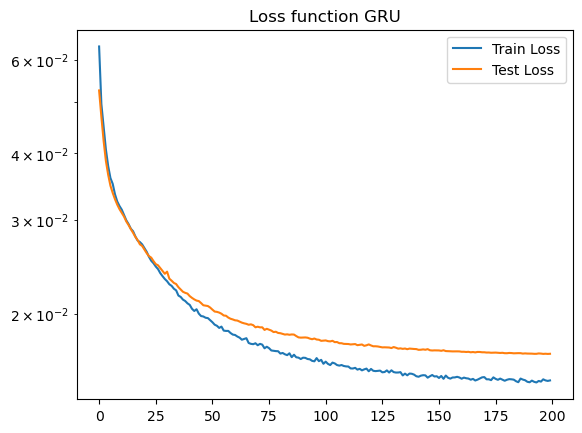

In [812]:
modelGRU, train_lossArrGRU, test_lossArrGRU = train_model(modelGRU, 200, 0.98, 9.5e-3, 5e-6, "GRU")
evaluate_model(modelGRU, "GRU", train_lossArrGRU, test_lossArrGRU)

In [ ]:
for x_vals, y_vals in trainData:
    x_vals, y_vals = x_vals.cuda(), y_vals.cuda()
    break
x_vals = x_vals.reshape(x_vals.shape[0], nD, 3*dof)
y_vals = y_vals.reshape(y_vals.shape[0], nD, 2*dof)
out = modelGRU(x_vals)
index = 6
x_vals = x_vals[index].reshape(nD, 3*dof)
states = x_vals[0, 0:2*dof].detach().cpu().numpy()
controls = x_vals[:, 2*dof:].detach().cpu().numpy()
print("states", states)
print("controls", controls)
print(compute_predictors(states, controls, None))
print(y_vals[index])
print(out[index])
print(torch.norm(y_vals[index, -1, :]-out[index, -1, :]))
#print(controlsExact[0:nD])
#print(x_vals[0, 14:])

In [ ]:
def ml_predictor_deeponet(state, controls, model):
    # The conversion time here actually can be expensive to go from CPU to GPU and back.
    inputs = np.zeros((controls.shape[0], dof*3))
    inputs[:, :2*dof] = np.tile(state, controls.shape[0]).reshape(controls.shape[0], 2*dof)
    inputs[:, 2*dof:] = controls
    inputs = inputs.reshape((1, controls.shape[0]*dof*3)).astype(np.float32)
    inputs = torch.from_numpy(inputs).cuda()
    output = model((inputs, grid)).detach().cpu().numpy().reshape(nD, 2*dof)
    x_vals = inputs[0].reshape(nD, 3*dof)
    states = x_vals[0, 0:2*dof].detach().cpu().numpy()
    controls = x_vals[:, 2*dof:].detach().cpu().numpy()
    print("diff", np.linalg.norm(output[-1]- compute_predictors(state, controls, None)[0]))
    return output[-1], output

def ml_predictor_rnn(state, controls, model):
    inputs = np.zeros((controls.shape[0], dof*3))
    inputs[:, :2*dof] = np.tile(state, controls.shape[0]).reshape(controls.shape[0], 2*dof)
    inputs[:, 2*dof:] = controls
    inputs = inputs.reshape((1, controls.shape[0], dof*3)).astype(np.float32)
    inputs = torch.from_numpy(inputs).cuda()
    with torch.no_grad():
        output = model(inputs).detach().cpu().numpy().reshape(nD, 2*dof)
        x_vals = inputs[0].reshape(nD, 3*dof)
        states = x_vals[0, 0:2*dof].detach().cpu().numpy()
        controls = x_vals[:, 2*dof:].detach().cpu().numpy()
        print("diff", np.linalg.norm(output[-1]- compute_predictors(state, controls, None)[0]))
    return output[-1], output

In [ ]:
T = 10
t = np.arange(0, T, dt)
qdes, qd_des, qdd_des = generate_trajectory(joint_lim_min, joint_lim_max, scaling, dt, T, D, (joint_lim_max +joint_lim_min) / 2.0 )

init_cond = (joint_lim_max +joint_lim_min) / 2.0 
init_cond = np.array([init_cond, np.zeros(dof)]).reshape(2*dof)
statesExact, controlsExact, predictorsExact = simulate_system(init_cond, qdes, qd_des, qdd_des, dt, T, D, dof, compute_predictors, None)

In [ ]:
#statesDeepONet, controlsDeepONet, predictorsDeepONet = simulate_system(init_cond, qdes, qd_des, qdd_des, dt, T, D, dof, ml_predictor_deeponet, modelDeepONet)
statesGRU, controlsGRU, predictorsGRU = simulate_system(init_cond, qdes, qd_des, qdd_des, dt, T, D, dof, ml_predictor_rnn, modelGRU)

In [ ]:
#plt.plot(statesDeepONet[:, 1], label="DeepONet")
plt.plot(statesGRU[:, 1], label="GRU")
plt.plot(statesExact[:, 1], label="Exact")
plt.plot(qdes[:, 1], label="des")
plt.legend()

In [334]:
dt = 0.1

spatial = np.arange(0, D+2*dt, dt/(dof)).astype(np.float32)
grid=torch.from_numpy(spatial.reshape((len(spatial), 1))).cuda()
nD = int(round(D/dt))
modelDeepONet = DeepONetProjected(grid.shape[0], 1, 48, 2*dof).cuda()
joint_lim_min = np.array([-1.7016, -2.147, -3.0541, -0.05, -3.059, -1.571, -3.059])
joint_lim_max = np.array([1.7016, 1.047, 3.0541, 2.618, 3.059, 2.094, 3.059])

init_cond = (joint_lim_max - joint_lim_min) / 2.0
init_cond = np.array([init_cond, np.zeros(7)]).reshape(int(2*dof))
controllerStatic = compute_control(init_cond, init_cond[:dof], np.zeros(dof), np.zeros(dof))
controls  = np.tile(controllerStatic, nD)
controls = controls.reshape((nD, dof))

start = time.time()
for i in range(1):
    res1 = compute_predictors(init_cond, controls, None)
end = time.time()
numerical_time = end-start
print("Numerical time", numerical_time)
start = time.time()
for i in range(1):
     res2 = ml_predictor_deeponet(init_cond, controls, modelDeepONet)
end = time.time()
ml_time_deeponet = end-start
print("ML time DeepONet", ml_time_deeponet)
print("Speedup DeepONet", numerical_time/ml_time_deeponet)
# start = time.time()
# for i in range(1000):
#     delay = np.random.uniform(0.5, 1.7)
#     ml_predictor_fno(state, x, delay, x, modelFNO)
# end = time.time()
# ml_time_fno = end-start
# print("ML time FNO", ml_time_fno)
# print("Speedup FNO", numerical_time/ml_time_fno)

Numerical time 0.08923482894897461
ML time DeepONet 0.0010101795196533203
Speedup DeepONet 88.33561482180788
[ 1.7016     -0.09680104  3.0541      2.618       3.059       2.094
  3.059       2.         -2.          2.          2.          4.
  4.          4.        ]
[ 0.12034355  0.15900195  0.16582195  0.02872089 -0.11927064 -0.14420223
  0.26611748  0.05298803 -0.17959836  0.10778254  0.21658355  0.0886845
 -0.40950945 -0.1255613 ]
